In [15]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import csv 
import datetime as dt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
#tf.config.set_visible_devices([], 'GPU')

In [16]:
#Grab Data
BTC = pd.read_csv("data/CBSE_BTC_clean1.csv")
ETH = pd.read_csv("data/CBSE_ETH_clean1.csv")

In [17]:
#Downsize
BTC_subset = BTC[0:600_000]
ETH_subset = ETH[0:600_000]
BTC_X = BTC_subset.loc[:,"timestamp":"volume"]
ETH_X = ETH_subset.loc[:,"timestamp":"volume"]
ETH_X

,timestamp,open,high,low,close,volume
0,1640995200000,3675.81,3676.28,3675.56,3676.12,1.531696
1,1640995201000,3675.55,3675.98,3675.44,3675.80,0.346709
2,1640995202000,3675.44,3675.44,3675.44,3675.44,0.256209
3,1640995203000,3675.73,3675.73,3675.44,3675.68,0.081256
4,1640995204000,3675.65,3675.65,3675.65,3675.65,0.028732
...,...,...,...,...,...,...
599995,1641595195000,3193.97,3194.38,3193.97,3194.38,0.054920
599996,1641595196000,3194.38,3194.38,3194.38,3194.38,0.045466
599997,1641595197000,3193.97,3193.97,3193.96,3193.96,0.034612
599998,1641595198000,3194.48,3194.48,3194.46,3194.46,0.090668


In [18]:
def get_direction(df):
    returns = pd.DataFrame(df['close'] / df['close'].shift(1) - 1)
    result = np.where(returns > 0, 1, -1)
    return result

BTC_Y = get_direction(BTC_X)
ETH_Y = get_direction(ETH_X)
#XRP_Y = get_direction(XRP_X)
"""
if("Direction" not in BTC_X.columns):
    BTC_X["Direction"] = BTC_Y
if("Direction" not in ETH_X.columns):
    ETH_X["Direction"] = ETH_Y
    """


'\nif("Direction" not in BTC_X.columns):\n    BTC_X["Direction"] = BTC_Y\nif("Direction" not in ETH_X.columns):\n    ETH_X["Direction"] = ETH_Y\n    '

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(BTC_X)
Y = BTC_Y
#X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, BTC_Y.ravel(), test_size=0.30, random_state=1)

ts_split = TimeSeriesSplit(n_splits = 10)
split_indices = ts_split.split(X_scaled) #generates train/test indices for scaled df
for train_ind, test_ind in split_indices:
    #initializes the (x,y) values of the train test split
    x_train, x_test = X_scaled[:len(train_ind)], X_scaled[len(train_ind): (len(train_ind) + len(test_ind))]
    y_train, y_test = Y[:len(train_ind)].ravel(), Y[len(train_ind): (len(train_ind)+len(test_ind))].ravel()

trainX = np.array(x_train)
testX = np.array(x_test)
x_train = trainX.reshape(x_train.shape[0], x_train.shape[1])
x_test = testX.reshape(x_test.shape[0], x_test.shape[1])

BTCmodel = MLPClassifier(max_iter = 250)
BTCmodel.fit(x_train, y_train)

MLPClassifier(max_iter=250)

In [27]:
pred = BTCmodel.predict(x_test)
print(f"Testing Accuracy: {accuracy_score(y_test, BTCmodel.predict(x_test))}")
print(f"Training Accuracy: {accuracy_score(y_train, BTCmodel.predict(x_train))}")
confusion_matrix(y_test, pred)

Testing Accuracy: 0.9911082592354936
Training Accuracy: 0.9978715017737485


54545

In [21]:
# Backtest
wealth = 1_000_000
testperiod = BTC_X.tail(len(x_test))

cum_return = []
for i in range(len(testperiod)-1):
    if(pred[i+1] == 1):
        cum_return.append(testperiod.iloc[(i+1),4] / testperiod.iloc[i,4] - 1)
    else:
        cum_return.append(0)

daily_portfolio = [wealth]
for _ in range(1,len(cum_return)):
    prev = daily_portfolio[_ - 1]
    daily_portfolio.append(prev + wealth*cum_return[_])
#daily_portfolio


Portfolio Return: 0.00%
BTC Return: -9.83%


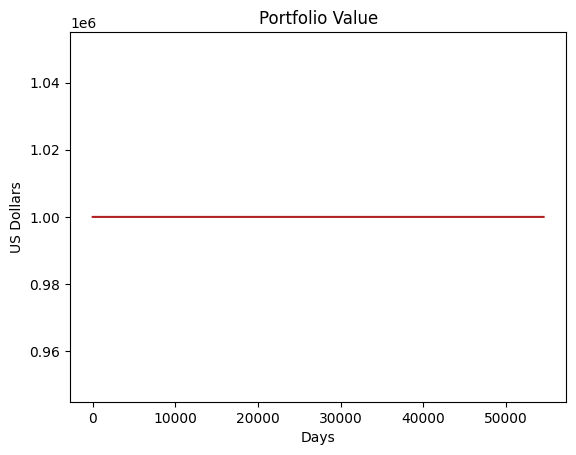

In [22]:
plt.plot(daily_portfolio, color = 'firebrick')
plt.xlabel("Days")
plt.ylabel("US Dollars")
plt.title("Portfolio Value")
print(f"Portfolio Return: {(daily_portfolio[-1]/daily_portfolio[0]-1)*100:.2f}%")
print(f"BTC Return: {(BTC_X.loc[:,'close'][len(BTC_X) -1] / BTC_X.loc[:,'close'][0] - 1)*100:.2f}%")

Text(0.5, 1.0, 'BTC Price')

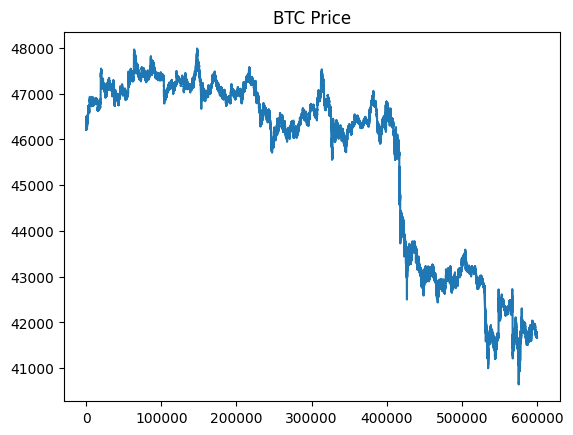

In [23]:
plt.plot(BTC_X.loc[:,"close"])
plt.title("BTC Price")

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ETH_X)
Y = ETH_Y
#X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, BTC_Y.ravel(), test_size=0.30, random_state=1)

ts_split = TimeSeriesSplit(n_splits = 10)
split_indices = ts_split.split(X_scaled) #generates train/test indices for scaled df
for train_ind, test_ind in split_indices:
    #initializes the (x,y) values of the train test split
    x_train, x_test = X_scaled[:len(train_ind)], X_scaled[len(train_ind): (len(train_ind) + len(test_ind))]
    y_train, y_test = Y[:len(train_ind)].ravel(), Y[len(train_ind): (len(train_ind)+len(test_ind))].ravel()

trainX = np.array(x_train)
testX = np.array(x_test)
x_train = trainX.reshape(x_train.shape[0], x_train.shape[1])
x_test = testX.reshape(x_test.shape[0], x_test.shape[1])

ETHmodel = MLPClassifier(max_iter = 250)
ETHmodel.fit(x_train, y_train)

In [ ]:
pred = ETHmodel.predict(x_test)
print(f"Testing Accuracy: {accuracy_score(y_test, ETHmodel.predict(x_test))}")
print(f"Training Accuracy: {accuracy_score(y_train, ETHmodel.predict(x_train))}")
confusion_matrix(y_test, pred)

In [ ]:
# Backtest
wealth = 1_000_000
testperiod = ETH_X.tail(len(x_test))

cum_return = []
for i in range(len(testperiod)-1):
    if(pred[i+1] == 1):
        cum_return.append(testperiod.iloc[(i+1),4] / testperiod.iloc[i,4] - 1)
    else:
        cum_return.append(0)

daily_portfolio = [wealth]
for _ in range(1,len(cum_return)):
    prev = daily_portfolio[_ - 1]
    daily_portfolio.append(prev + wealth*cum_return[_])
#daily_portfolio


In [ ]:
plt.plot(daily_portfolio, color = 'firebrick')
plt.xlabel("Days")
plt.ylabel("US Dollars")
plt.title("Portfolio Value")
print(f"Portfolio Return: {(daily_portfolio[-1]/daily_portfolio[0]-1)*100:.2f}%")
print(f"ETH Return: {(ETH_X.loc[:,'close'][len(ETH_X) -1] / ETH_X.loc[:,'close'][0] - 1)*100:.2f}%")

In [ ]:
plt.plot(ETH_X.loc[:,"close"])
plt.title("ETH Price")